In [2]:
import MDAnalysis as mda
import numpy as np
from mdcraft.analysis.polymer import EndToEndVector, Gyradius
from matplotlib import pyplot as plt

/home/kfu/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load Data

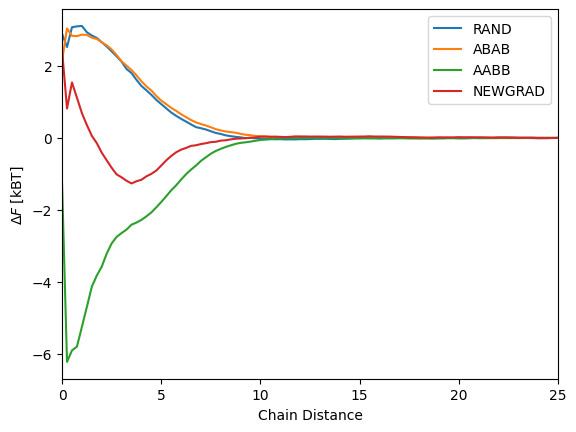

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Define the sequences
sequences = ['RAND', 'ABAB', 'AABB', 'NEWGRAD']

# Initialize the plot
plt.clf()

# Plot data for each sequence
for seq in sequences:
    tag = f'poly_sequ_{seq}_N_2_nchain_2_temp_1_pmf'
    data = np.loadtxt(f'../data/{tag}/prod.pmf', skiprows=3)
    plt.plot(data[:,0], data[:,1] - data[-1,1], label=seq)

# Add labels and legend
plt.xlabel('Chain Distance')
plt.ylabel(r'$\Delta F$ [kBT]')
plt.legend()
plt.xlim(0,25)

# Show the plot
plt.show()


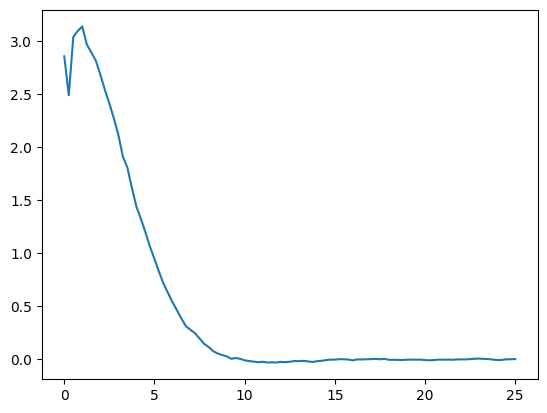

In [10]:
plt.clf()
plt.plot(data[:,0],data[:,1]-data[-1,1])

# Radius of Gyration

In [269]:
gyr = Gyradius(ag,n_chains=100,n_monomers=40, unwrap=True)

In [270]:
gyr.run(start=1000)

100%|██████████| 2001/2001 [00:00<00:00, 6312.60it/s]


In [271]:
np.savetxt('../data/'+tag+'/gyr.txt',gyr.results.gyradii)

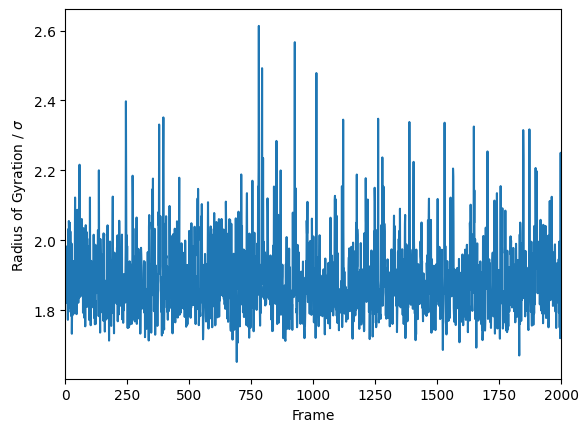

In [272]:
plt.plot(gyr.results.gyradii[0])
plt.xlabel('Frame')
plt.ylabel(f'Radius of Gyration / $\sigma$')
plt.xlim(0,2000)
plt.savefig('../data/'+tag+'/gyr.pdf')

# End-to-end Vector

In [273]:
e2e = EndToEndVector(ag,n_chains=1,n_monomers=40, unwrap=True)

/home/kfu/.local/lib/python3.10/site-packages/MDAnalysis/coordinates/base.py:725: UserWarning: Reader has no dt information, set to 1.0 ps
  return self.ts.dt


In [274]:
e2e.run(start=1000)
e2e.save('../data/'+tag+'/e2e')

/home/kfu/.local/lib/python3.10/site-packages/MDAnalysis/coordinates/LAMMPS.py:598: UserWarning: Reader has no dt information, set to 1.0 ps
  ts.data['time'] = step_num * ts.dt
100%|██████████| 2001/2001 [00:00<00:00, 8074.74it/s]
1it [00:00, 2693.84it/s]


In [275]:
abs_e2e = np.zeros(len(e2e._e2e))

for i in range(len(e2e._e2e)):
    abs_e2e[i] = np.linalg.norm(e2e._e2e[i])

abs_e2e

array([2.23543372, 1.07988825, 1.16543384, ..., 3.27568639, 4.67249535,
       2.97711096])

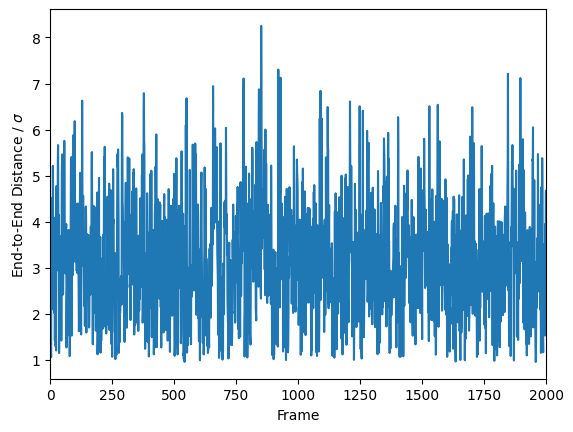

In [276]:
plt.plot(e2e.results.times,abs_e2e)
plt.xlabel('Frame')
plt.ylabel('End-to-End Distance / $\sigma$')
plt.xlim(0,2000)
plt.savefig('../data/'+tag+'/e2e.pdf')

/tmp/ipykernel_3005737/900919511.py:4: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0,3000)


(0.6838305520458344, 3000)

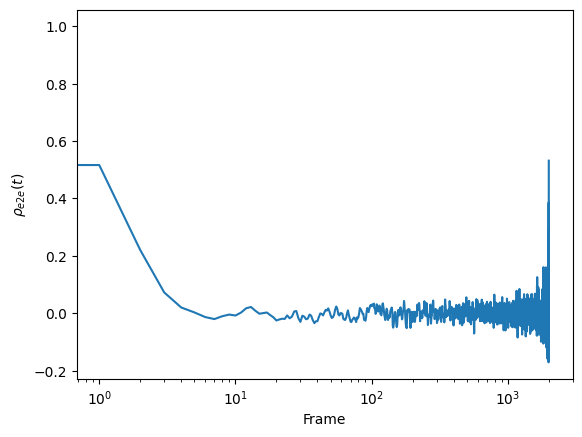

In [277]:
plt.semilogx(e2e.results.times,e2e.results.acf[0][0])
plt.xlabel('Frame')
plt.ylabel(r'$ \rho_{e2e}(t)$')   
plt.xlim(0,3000)